In [ ]:
!pip install medmnist scikit-learn matplotlib torcheval torchmetrics

In [ ]:
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import ParameterSampler, KFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score, roc_auc_score
from torcheval.metrics import MulticlassAUPRC, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
import medmnist
from torch.utils.data import ConcatDataset
from medmnist import INFO, Evaluator
import random
import torch

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 64
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: 

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


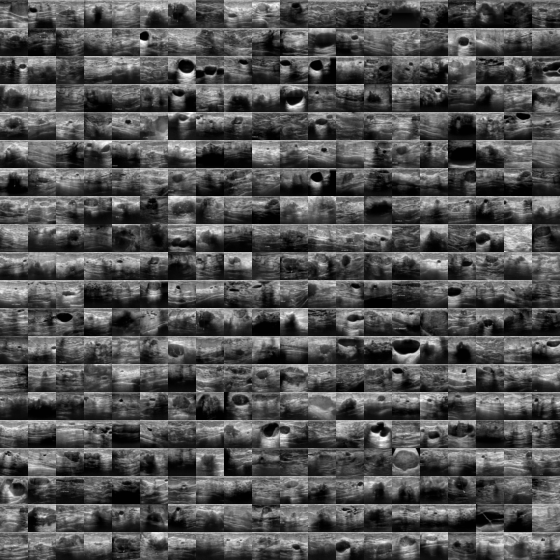

In [ ]:
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [ ]:
# Define a simple CNN model
class Net(nn.Module):
    def __init__(self, in_channels, num_classes, dropout):
        super(Net, self).__init__()

        self.Net = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.Net.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)

        number_features = self.Net.fc.in_features

        self.Net.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(number_features, num_classes)
        )

        self.Net = self.Net.to(device)

    def forward(self, x):
        x = self.Net(x)
        return x

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net(in_channels=n_channels, num_classes=n_classes, dropout=0.3)

# Move the model to the device
model.to(device)

# Define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

# Use Adam optimiser
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best Hyperparameters:
lr=0.001, weight_decay=0.0001, step_size=20, gamma=0.1, NUM_EPOCHS = 10, BATCH_SIZE = 64

In [ ]:
flag = False
if flag == True:
  # Define the hyperparameter search space
  hyperparameters_space = {
      'lr': [0.01, 0.001, 0.0001],
      'batch_size': [16, 32, 64, 128],
      'epochs': [5, 10],
      'weight_decay': [0.0, 0.01, 0.001, 0.0001],
      'step_size': [5, 10, 15, 20],
      'gamma': [0.1, 0.2, 0.3, 0.4],
      'dropout': [0.1, 0.2, 0.3, 0.4]
  }

  # Perform random search using random.choices
  n_iter_search = 100
  random_search = [random.choices(options, k=n_iter_search) for options in hyperparameters_space.values()]
  hyperparameters_combinations = [{'lr': lr, 'batch_size': batch_size, 'epochs': epochs,
                                  'weight_decay': weight_decay, 'step_size': step_size, 'gamma': gamma,
                                  'dropout': dropout}
                                  for lr, batch_size, epochs, weight_decay, step_size, gamma, dropout
                                  in zip(*random_search)]

  best_val_auc = 0.0
  best_val_acc = 0.0
  best_hyperparameters = None

  # Hyperparameter tuning loop
  for hyperparameters in hyperparameters_combinations:
      model = Net(in_channels=1, num_classes=2, dropout=hyperparameters['dropout']).to(device)
      optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])
      scheduler = StepLR(optimizer, step_size=hyperparameters['step_size'], gamma=hyperparameters['gamma'])
      criterion = nn.CrossEntropyLoss()

      for epoch in range(hyperparameters['epochs']):
          # Training loop
          model.train()
          for inputs, targets in tqdm(train_loader):
              inputs, targets = inputs.to(device), targets.to(device)
              optimizer.zero_grad()
              outputs = model(inputs)
              targets = torch.argmax(targets, dim=1)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
          scheduler.step()

      # Evaluation on the validation set
      model.eval()
      y_true = torch.tensor([])
      y_score = torch.tensor([])

      with torch.no_grad():
          for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              if task == 'multi-label, binary-class':
                  targets = targets.to(torch.float32)
                  outputs = outputs.softmax(dim=-1)
              else:
                  targets = targets.squeeze().long()
                  outputs = outputs.softmax(dim=-1)
              y_true = torch.cat((y_true, targets.cpu()), 0)
              y_score = torch.cat((y_score, outputs.cpu()), 0)

      y_true = y_true.numpy()
      y_score = y_score.detach().numpy()

      evaluator = Evaluator(data_flag, 'val')
      metrics = evaluator.evaluate(y_score)
      auc = metrics[0]
      acc = metrics[1]

      # Check if this is the best model so far
      if auc > best_val_auc or (auc == best_val_auc and acc > best_val_acc):
          best_val_acc = acc
          best_val_auc = auc
          best_hyperparameters = hyperparameters
          print('New best acc:', best_val_acc)
          print('New best auc:', best_val_auc)

  print('Best Validation Accuracy: ', best_val_acc)
  print('Best Validation Area under ROC: ', best_val_auc)
  print('Best Hyperparameters: ', best_hyperparameters)


# New section

## Next, we can start to train and evaluate!

In [ ]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        # Move inputs and targets to the correct device
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
    scheduler.step()

100%|██████████| 9/9 [00:00<00:00, 35.74it/s]


In [ ]:
# Code to load the best trained model
load_model = True

if load_model == True:
  model.load_state_dict(torch.load('best_saved_model.pth'))

Best evaluation metrics:
train  auc: 1.000,  acc:0.996
test  auc: 0.929,  acc:0.885,  aupr: 0.900,  f1: 0.841

==> Evaluating ...
train  auc: 1.000  acc:0.996  aupr: 1.000  precision: 0.998  recall: 0.993  f1: 0.995


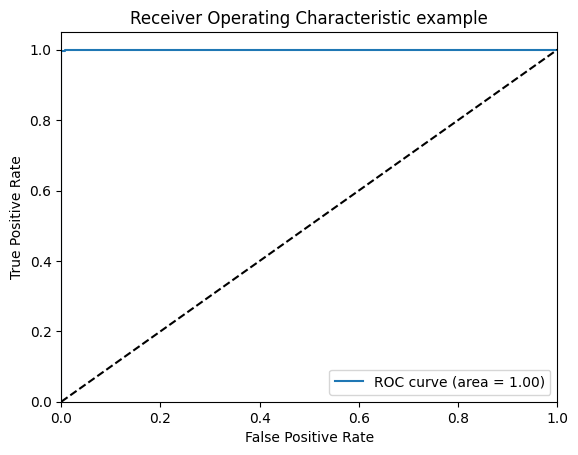

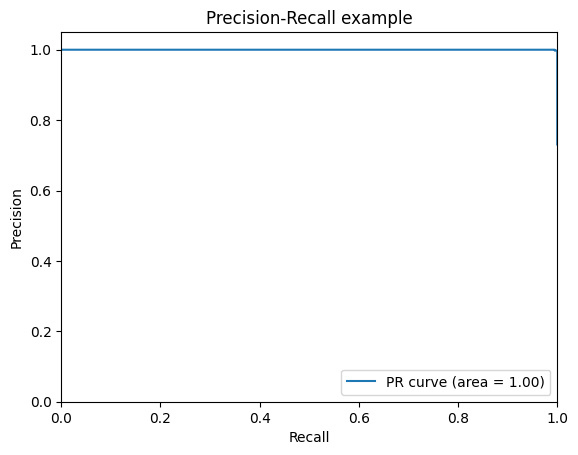

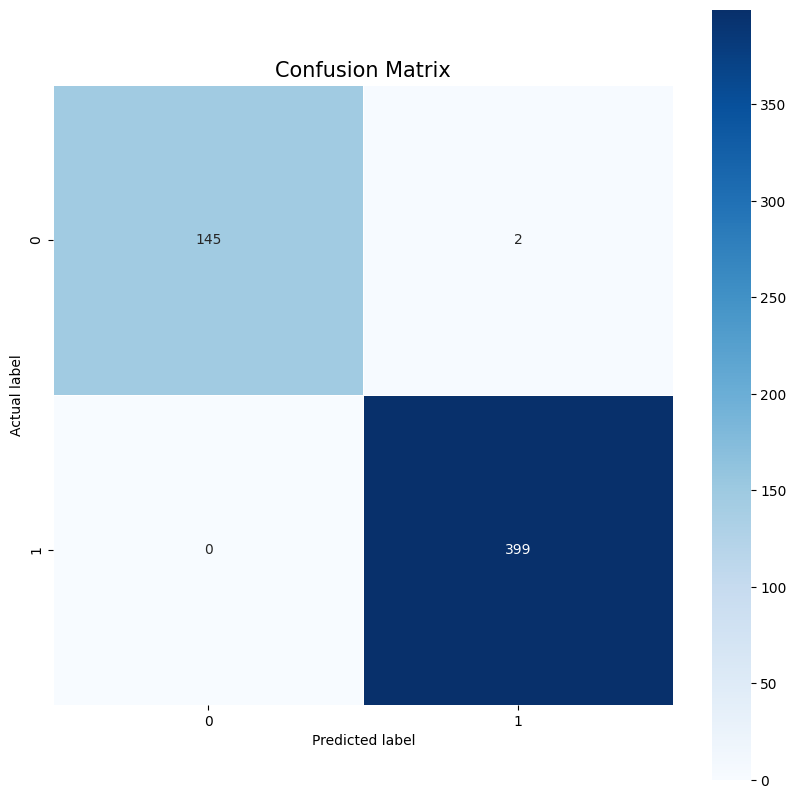

test  auc: 0.929  acc:0.885  aupr: 0.900  precision: 0.881  recall: 0.816  f1: 0.841


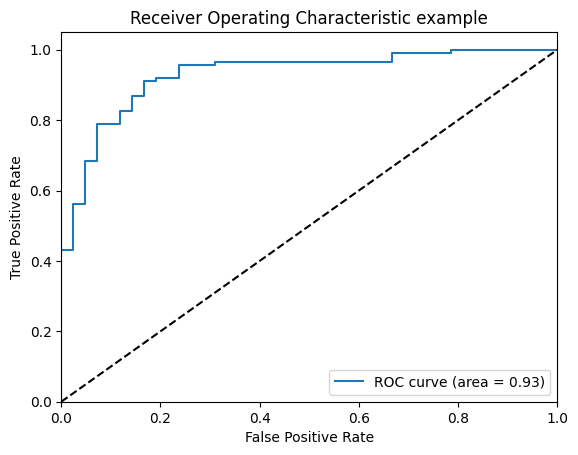

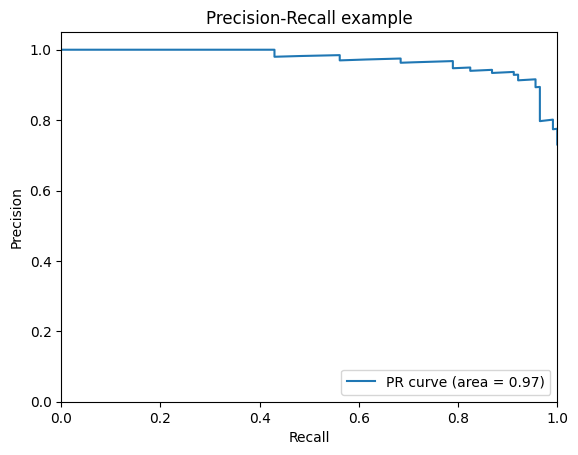

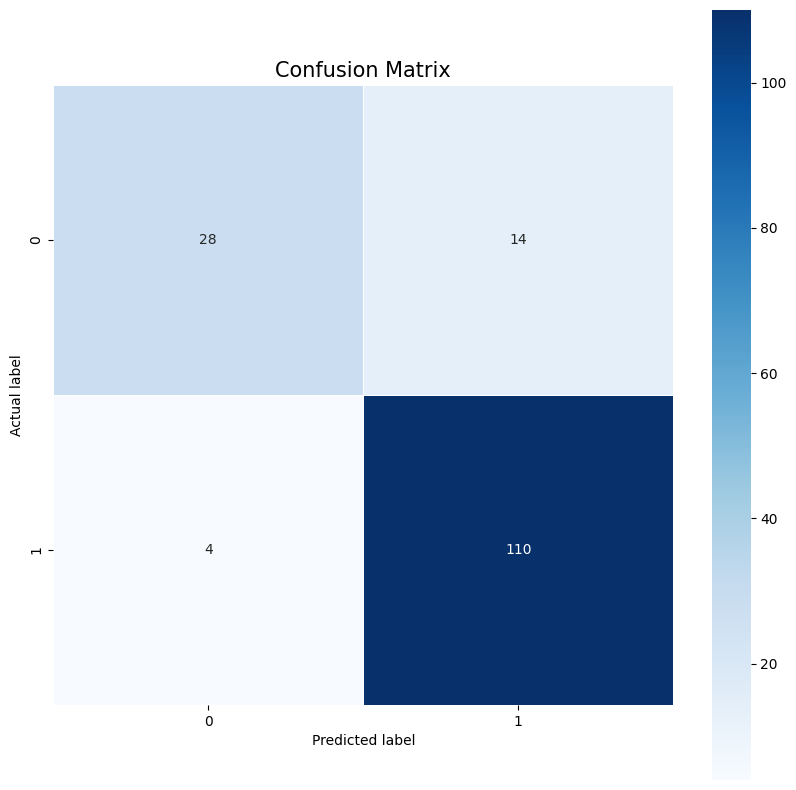

In [ ]:
# evaluation
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def plot_pr_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score[:, 1])
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, label='PR curve (area = %0.2f)' % pr_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall example')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title('Confusion Matrix', size = 15);
    plt.show()

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    aupr = MulticlassAUPRC(num_classes=n_classes)
    precision = MulticlassPrecision(num_classes=n_classes, average='macro')
    recall = MulticlassRecall(num_classes=n_classes, average='macro')
    f1 = MulticlassF1Score(num_classes=n_classes, average='macro')

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            aupr.update(outputs, targets.squeeze())
            precision.update(outputs, targets.squeeze())
            recall.update(outputs, targets.squeeze())
            f1.update(outputs, targets.squeeze())

            if task == 'multi-label, binary-class':
                targets = targets.unsqueeze(1).to(torch.float32)
                outputs = outputs.unsqueeze(1).softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets.cpu()), 0)
            y_score = torch.cat((y_score, outputs.cpu()), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        y_pred = np.argmax(y_score, axis=1)

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        aupr_score = aupr.compute()
        precision_score = precision.compute()
        recall_score = recall.compute()
        f1_score = f1.compute()
        print('%s  auc: %.3f  acc:%.3f  aupr: %.3f  precision: %.3f  recall: %.3f  f1: %.3f' % (split, *metrics, aupr_score, precision_score, recall_score, f1_score))

        plot_roc_curve(y_true, y_score)

        plot_pr_curve(y_true, y_score)

        plot_confusion_matrix(y_true, y_pred)

print('==> Evaluating ...')
test('train')
test('test')

5-fold metrics:
Validation Accuracy: 0.8333333333333334, Validation AUC: 0.7625025725457912

Fold 5: Accuracy: 0.8589743589743589, AUC: 0.7681704260651628

Average Accuracy: 0.8461538461538461, Average AUC: 0.760345032162294

In [ ]:
merged_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize lists to store accuracies and AUCs
accuracies = []
aucs = []

for fold, (train_val_indices, test_indices) in enumerate(kf.split(range(len(merged_dataset)))):
    train_indices, val_indices = train_val_indices[:len(train_val_indices)*3//4], train_val_indices[len(train_val_indices)*3//4:]

    # Convert numpy arrays to lists
    train_indices = train_indices.tolist()
    val_indices = val_indices.tolist()
    test_indices = test_indices.tolist()

    train_data = torch.utils.data.Subset(merged_dataset, train_indices)
    val_data = torch.utils.data.Subset(merged_dataset, val_indices)
    test_data = torch.utils.data.Subset(merged_dataset, test_indices)

    # Define data loaders based on the split indices
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=2*BATCH_SIZE, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=2*BATCH_SIZE, shuffle=False)

    # Reset the model and optimizer
    model = Net(in_channels=n_channels, num_classes=n_classes, dropout=0.3)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

    # Train the model
    for epoch in range(NUM_EPOCHS):
        model.train()
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluate the model on validation data
    model.eval()
    val_true = []
    val_pred = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_true.extend(targets.tolist())
            val_pred.extend(predicted.tolist())

    # Calculate validation accuracy and AUC
    val_accuracy = accuracy_score(val_true, val_pred)
    val_auc = roc_auc_score(val_true, val_pred)
    print(f"Validation Accuracy: {val_accuracy}, Validation AUC: {val_auc}")


    # Evaluate the model
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(targets.tolist())
            y_pred.extend(predicted.tolist())

    # Calculate accuracy and AUC
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    accuracies.append(accuracy)
    aucs.append(auc)

    print(f"Fold {fold+1}: Accuracy: {accuracy}, AUC: {auc}")

print(f"Average Accuracy: {np.mean(accuracies)}, Average AUC: {np.mean(aucs)}")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 8/8 [00:00<00:00, 28.92it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' ins

Validation Accuracy: 0.8333333333333334, Validation AUC: 0.7957393483709273
Fold 1: Accuracy: 0.8397435897435898, AUC: 0.7914657666345226


100%|██████████| 8/8 [00:00<00:00, 21.25it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Validation Accuracy: 0.7948717948717948, Validation AUC: 0.761904761904762
Fold 2: Accuracy: 0.8397435897435898, AUC: 0.8333333333333333


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 8/8 [00:00<00:00, 28.32it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torc

Validation Accuracy: 0.8461538461538461, Validation AUC: 0.7281333607738218
Fold 3: Accuracy: 0.8141025641025641, AUC: 0.7042042042042042


100%|██████████| 8/8 [00:00<00:00, 28.84it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Accuracy: 0.8846153846153846, Validation AUC: 0.8547008547008547
Fold 4: Accuracy: 0.8461538461538461, AUC: 0.7969811320754717


100%|██████████| 8/8 [00:00<00:00, 27.85it/s]


Validation Accuracy: 0.8205128205128205, Validation AUC: 0.7608561432393496
Fold 5: Accuracy: 0.8141025641025641, AUC: 0.7224310776942356
Average Accuracy: 0.8307692307692308, Average AUC: 0.7696831027883535
